# <center> Lecture15 : Hierarchical Models (2)</center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## Intro  

在上一节课程中，我们学习了层级模型的基本概念，考虑了自我控制分数在不同站点和不同个体间的变化。  

🤔 然而，我们更想回答的问题是，压力对自我控制的影响是否在不同站点间存在差异？  

* 一种可能是，自我控制分数在不同站点间存在差异，但是压力对自我控制的影响在不同站点不存在差异。  
* 另一种可能是，站点只调节压力对自我控制的影响，而各站点间自我控制分数相当。  
* 最后，站点可能既影响自我控制分数，又影响压力对自我控制的效应。  

![Image Name](https://cdn.kesci.com/upload/s5sh35okpe.png?imageView2/0/w/640/h/640)  


在本节课中，我们将介绍引入包含自变量时的层级模型，并通过不同的模型验证不同的假设：  
* H0(model 0)，图A，普通线性模型，仅考虑压力对自我控制的影响。  
* H1(model 1)，图B，变化截距模型，在模型0的基础上考虑自我控制在不同站点的变化。  
* H2(model 2)，图C，变化斜率模型，在模型0的基础上不同站点间的压力影响的变化。  
* H3(model 3)，图D，变化截距和斜率模型，结合模型1和模型2，同时考虑站点对自我控制以及压力影响的变化。  

![Image Name](https://cdn.kesci.com/upload/s5sh35okpe.png?imageView2/0/w/640/h/640)

In [3]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')
# 选取所需站点
first5_site = ['Southampton','Portugal','Kassel','Tsinghua','UCSB']
df_first5 = df_raw.query("Site in @first5_site")
# 生成站点索引
df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]
# 生成被试数索引
df_first5["obs_id"] = range(len(df_first5))
# 将站点、被试id设置为索引
df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)


In [48]:
df_raw["Site"].unique()

array(['Bamberg', 'Chile', 'Kassel', 'METU', 'Oslo', 'Oxford', 'Poland',
       'Portugal', 'Serbia', 'SMU', 'Southampton', 'Tsinghua', 'UCSB',
       'VCU', 'Zurich'], dtype=object)

## Model0: Complete pooling  

如果我们忽略数据的层级结构，认为所有数据都来自一个更大的总体，只需要用一个回归方程来描述自变量与因变量的关系。  

此时的回归模型采样了完全池化 (complete) 方法，对应假设0 (H0) 和模型0 (model 0):  

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} &   Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\  

\text{priors:} & & \beta_{0}  & \sim N\left(0, 50^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 5^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(1)  \\  
\end{array}  
$$ 

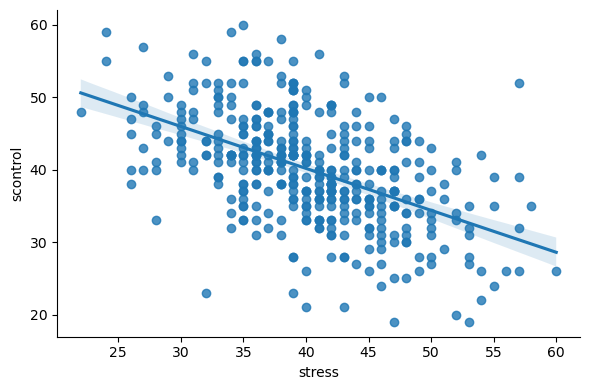

In [5]:
# 通过完全池化的方式可视化数据
sns.lmplot(df_first5,
           x="stress",
           y="scontrol",
           height=4, aspect=1.5)

### 模型定义与采样

In [6]:
# 注意，以下代码可能运行2分钟左右

coords = {"obs_id": df_first5.obs_id}
with pm.Model(coords=coords) as complete_pooled_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=50)                #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5)                 #定义beta_1
    sigma = pm.Exponential("sigma", 1)                          #定义sigma

    x = pm.MutableData("x", df_first5.stress, dims="obs_id")    #x是自变量压力水平

    mu = pm.Deterministic("mu",beta_0 + beta_1 * x, 
                          dims="obs_id")                        #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_first5.scontrol,
                           dims="obs_id")                       #定义似然：预测值y符合N(mu, sigma)分布
                                                                #通过 observed 传入实际数据y 自我控制水平
    complete_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


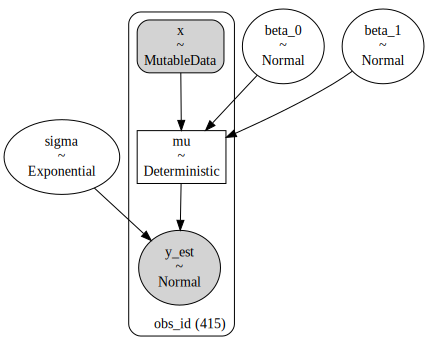

In [7]:
pm.model_to_graphviz(complete_pooled_model)

### 后验参数估计：  

结果显示：  

$\mu_i = \beta_0 + \beta_1X_i$  
- $\beta_0 = 63.17$  
- $\beta_1 = -0.58$

In [8]:
az.summary(complete_trace,
           var_names=["~mu"],
           filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,63.267,1.951,59.451,66.735,0.055,0.039,1249.0,1369.0,1.0
beta_1,-0.577,0.048,-0.666,-0.487,0.001,0.001,1241.0,1245.0,1.0
sigma,6.480,0.226,6.047,6.893,0.005,0.004,1780.0,1660.0,1.0


### 后验预测回归线  

* 完全池化模型假设，所有站点中自我控制分数一致，并且压力的影响也一致。  
* 下图展示了不同站点下后验预测的结果，可以看到他们的回归线是一致的。

In [9]:
#提取不同站点数据对应的索引并储存，便于后续将后验预测数据按照站点进行提取
def get_group_index(data):
    group_index = {}
    for i, group in enumerate(data["Site"].unique()):
        group_index[group] = xr.DataArray(data.query(f"Site == '{group}'"))["obs_id"].values
    return group_index

In [10]:
#定义函数，绘制不同站点下的后验预测回归线
def plot_regression(data, trace, group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                       sharex=True,
                       sharey=True,
                       figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        #绘制真实数据的散点图
        x = trace.constant_data.x.sel(obs_id = group_index[f"{group}"])
        y = trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"])
        mu = trace.posterior.mu.sel(obs_id = group_index[f"{group}"])
        ax[i].scatter(x, y,
                color=f"C{i}",
                alpha=0.5)
        #绘制回归线
        ax[i].plot(x, mu.stack(sample=("chain","draw")).mean(dim="sample"),
                color=f"C{i}",
                alpha=0.5)
        #绘制预测值95%HDI
        az.plot_hdi(
            x, mu,
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
    # 生成横坐标名称
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Posterior regression models", fontsize=15)
        
    sns.despine()

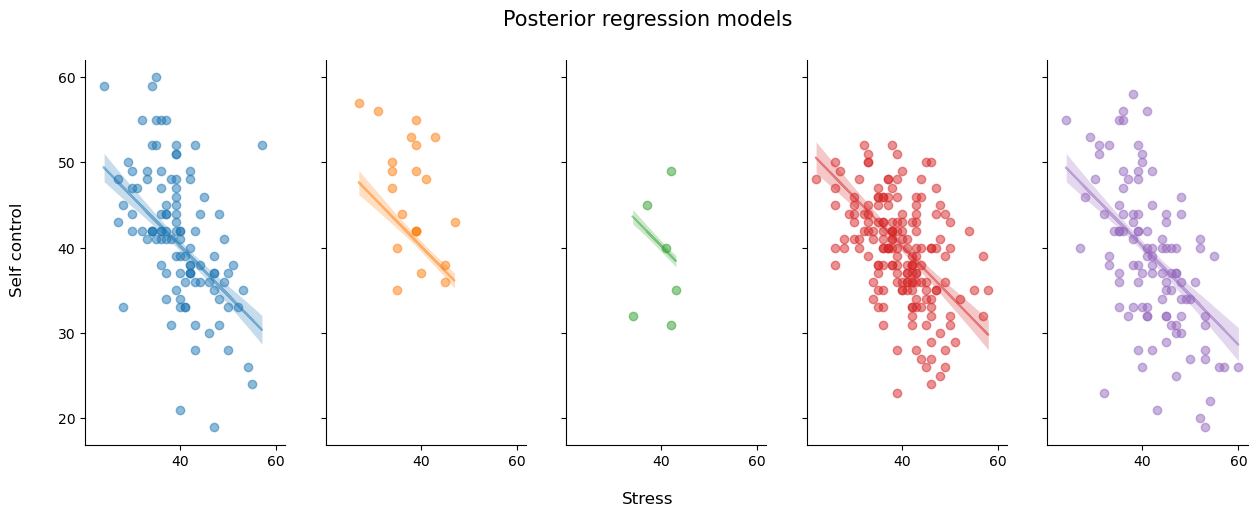

In [11]:
# 获取每个站点数据的索引
first5_index = get_group_index(data=df_first5)
# 进行可视化
plot_regression(data=df_first5,
                trace=complete_trace,
                group_index=first5_index)

## No pooling  

接下来我们暂时忽略总体信息，只考虑分组信息  

* 不同站点间，线性关系中的参数(斜率、截距)是相互独立的  

* 我们使用$j$来表示不同的站点，$j\in(0,1,2,3,4,5)$，从分布中抽取不同站点的参数  


$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} &   Y_i | \beta_0j, \beta_1j, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_{0j} + \beta_{1j}X_i \\  

\text{priors:} & & \beta_{0j}  & \sim N\left(0, 50^2 \right)  \\  
                    & & \beta_{1j}  & \sim N\left(0, 5^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(1)  \\  
\end{array}  
$$ 

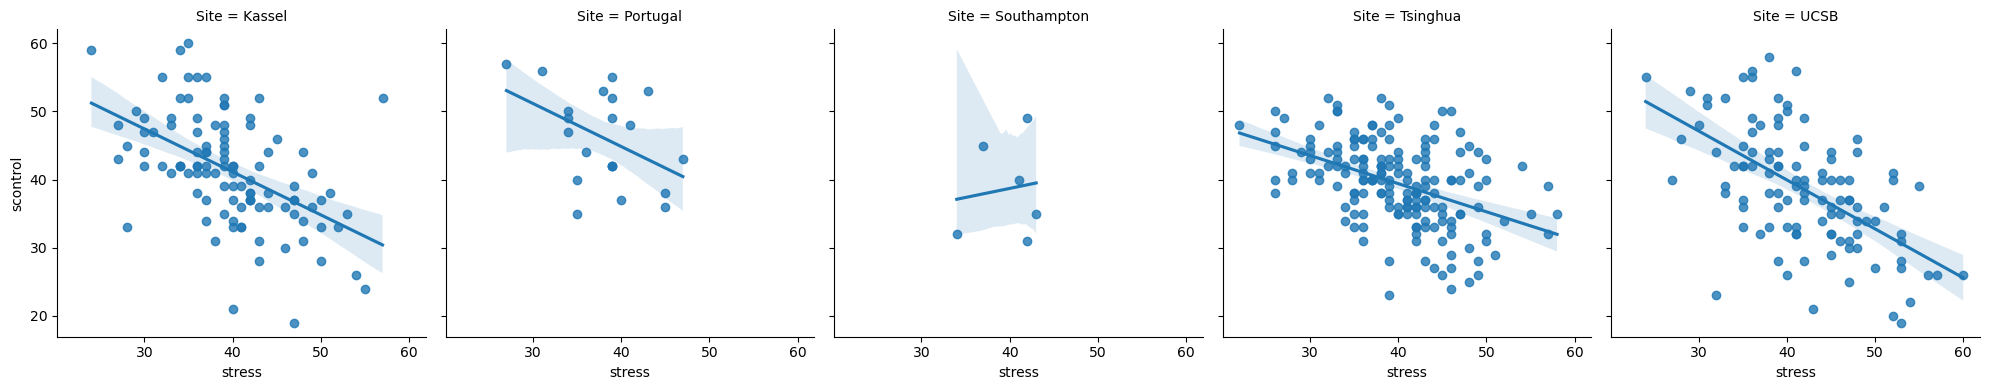

In [12]:
# 创建画图所需的网格数
g = sns.FacetGrid(df_first5, col="Site", col_wrap=5, height=4)

# 将各个图所画的内容对应到画布上
g.map(sns.regplot, "stress", "scontrol")

# Show the plot
plt.show()

### 模型定义与采样

In [13]:
# 注意，以下代码可能运行2分钟左右

coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as no_pooled_model:

    #定义截距、斜率，指定dims="site"，生成每个站点对应的截距、斜率
    beta_0 = pm.Normal("beta_0", mu=0, sigma=50, dims="site")
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5, dims="site")    
    #定义sigma，指定dims="site"，生成不同的sigma
    sigma = pm.Exponential("sigma", 2, dims="site") 

    #传入自变量、获得观测值对应的站点映射
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 
    x = pm.MutableData("x", df_first5.stress, dims="obs_id")

    #线性关系
    mu = pm.Deterministic("mu", beta_0[site]+beta_1[site]*x, dims="obs_id")
    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma[site], observed=df_first5.scontrol, dims="obs_id")

    no_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


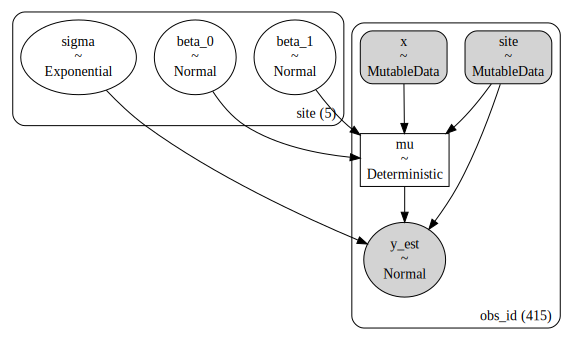

In [14]:
pm.model_to_graphviz(no_pooled_model)

###  后验参数估计  

* 可以看到每个站点的的截距(beta_0[xx])、斜率(beta_1[xx])，以及观测值所服从的正态分布中的标准差sigma[xx]都是不同的

In [15]:
az.summary(no_trace,
           var_names=["beta","beta_1"],
           filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0[Kassel],66.035,3.881,59.018,73.525,0.063,0.045,3779.0,2820.0,1.0
beta_0[Portugal],67.670,9.602,48.741,85.508,0.148,0.105,4256.0,2471.0,1.0
beta_0[Southampton],22.215,21.419,-19.411,62.777,0.349,0.267,3793.0,2639.0,1.0
beta_0[Tsinghua],55.841,2.474,51.031,60.336,0.045,0.032,3008.0,2698.0,1.0
beta_0[UCSB],68.337,3.957,60.864,75.787,0.064,0.045,3863.0,2727.0,1.0
beta_1[Kassel],-0.623,0.097,-0.808,-0.447,0.002,0.001,3807.0,2821.0,1.0
beta_1[Portugal],-0.568,0.251,-1.060,-0.099,0.004,0.003,4209.0,2687.0,1.0
beta_1[Southampton],0.412,0.537,-0.545,1.526,0.009,0.008,3820.0,2694.0,1.0
beta_1[Tsinghua],-0.411,0.061,-0.520,-0.289,0.001,0.001,3025.0,2991.0,1.0
beta_1[UCSB],-0.710,0.093,-0.895,-0.546,0.001,0.001,3945.0,2685.0,1.0


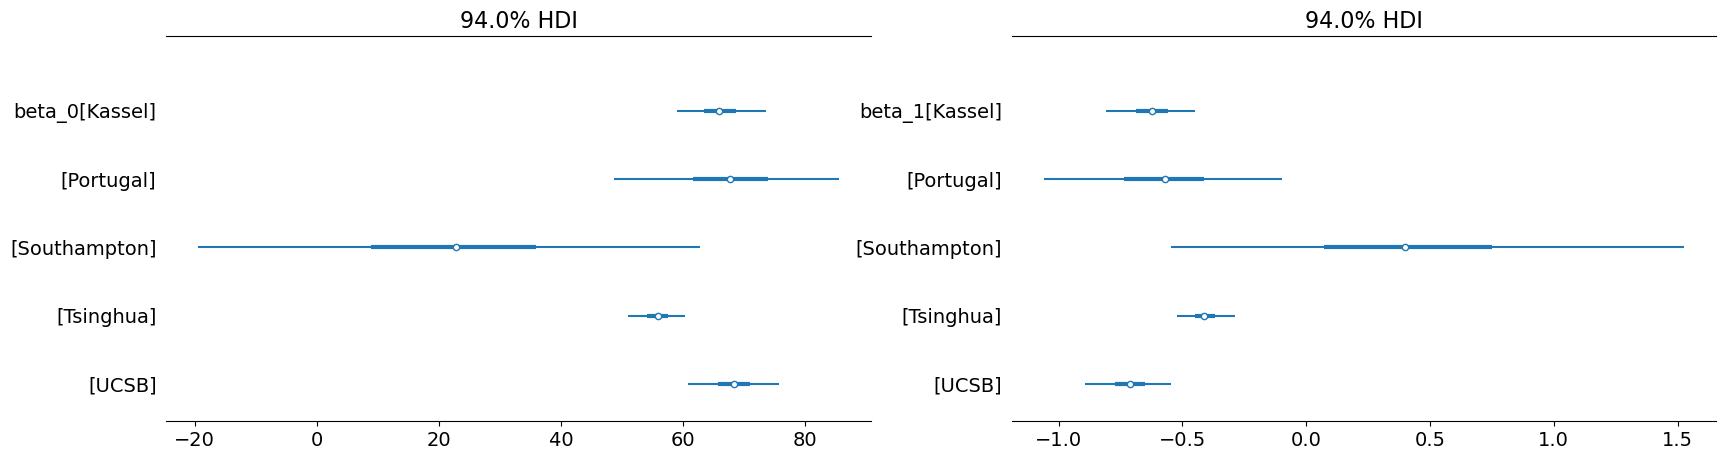

In [16]:
# 设置绘图坐标
figs, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
# 绘制变化的截距
az.plot_forest(no_trace,
           var_names=["~mu", "~sigma", "~offset", "~beta_1"],
           filter_vars="like",
           combined = True,
           ax=ax1)
# 绘制变化的斜率
az.plot_forest(no_trace,
           var_names=["~mu", "~sigma", "~offset", "~beta_0"],
           filter_vars="like",
           combined = True,
           ax=ax2)
plt.show()

### 后验预测回归线  

* 在非池化模型中，生成了5条斜率与截距各不相同的回归线  


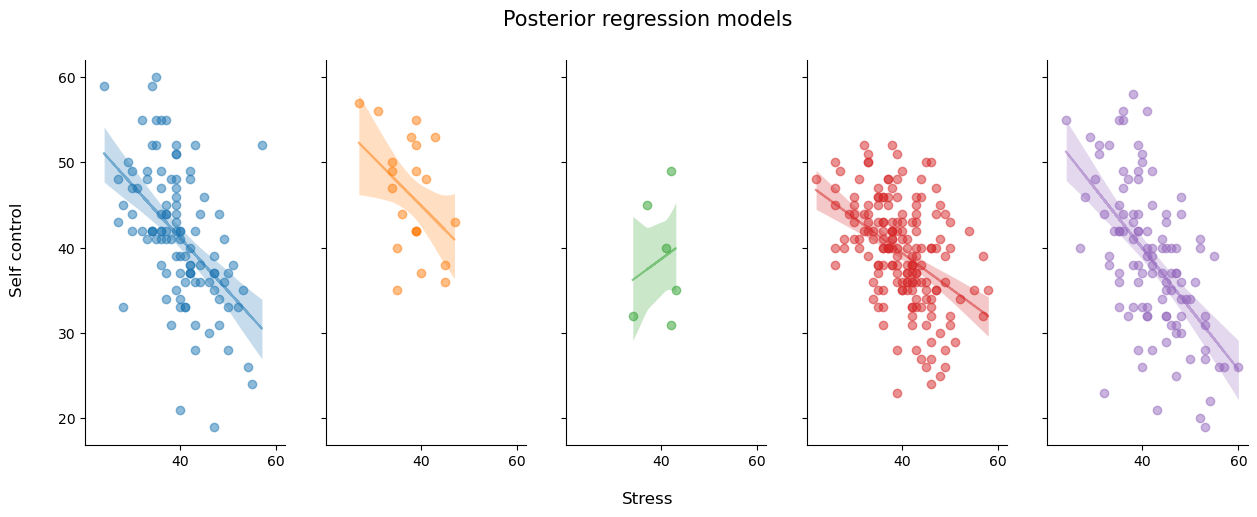

In [17]:
first5_index = get_group_index(data=df_first5)
plot_regression(data=df_first5,
                trace=no_trace,
                group_index=first5_index)

## Partial pooling & hierarchical model  

非池化模型 (no pooling)没有考虑总体和站点之间的关系，仅把不同站点当作独立群体。现在我们开始考虑如何使用部分池化方法 (partial pooling)来构建分层模型。  

* 考虑到不同站点下回归模型的截距 ($\beta_0$) 和斜率 ($\beta_1$) 都可能发生变化  
* 我们首先考虑截距 ($\beta_0$)随站点变化的模型 (model1，变化截距模型)  
* 然后再考虑斜率 ($\beta_1$) 随站点变化的模型 (model2，变化斜率模型)  
* 最后，我们同时考虑截距 ($\beta_0$)和斜率 ($\beta_1$) 随站点的变化 (model3，变化截距和斜率模型)  

![Image Name](https://cdn.kesci.com/upload/s5eeyrh0s5.png?imageView2/0/w/960/h/960)  

* $j$来表示站点，$j \in \{1,2, \ldots, 5\}$  
* $i$来表示站点内部的每一个数据$i \in \{1,2,\ldots,n_j\}$  
* 每一个被试的数据可以被表示为$Y_{ij}$，表示站点$j$内的第$i$个被试的自我控制分数观测值  

$$  
Y := \left((Y_{11}, Y_{21}, \ldots, Y_{n_1,1}), (Y_{12}, Y_{22}, \ldots, Y_{n_2,2}), \ldots, (Y_{1,5}, Y_{2,5}, \ldots, Y_{n_{5},5})\right)  .  
$$ 

##  Model1: Hierarchical model with varying intercepts  

相较于没有自变量的分层模型，构建包含自变量的分层模型的关键在于区分 **变量($\beta$)** 和 **分层(layer)** 的关系。  

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(每个站点内的线性模型)} \\  
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_0 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$

### Layer 1: Variability within Site  

**1. 自我控制与压力之间的关系在被试内有什么不同**  

$$  
Y_{ij} | \beta_{j}, \beta_1, \sigma_y \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ where } \; \mu_{ij} = \beta_{0j} + \beta_1 X_{ij}  .  
$$  

* 使用$i$表示每个站点内的第$i$个被试，$i \in (1,2,3...n)$  
* 对于每一个被试来说，其自我控制分数服从以$\mu_{ij}$为均值，$\sigma_y$为标准差的正态分布  

* 而$\mu_{ij}$由参数$\beta_{0j}$，$\beta_1$决定  

    * 其中，$\beta_{0j}$在组与组之间不同(group-specific)  

    * $\beta_1$和$\sigma_y$则是相同的(global)

### Layer 2: Variability between Site  
**2. 自我控制与压力之间的线性关系在站点间有什么不同**  

* 自我控制与压力之间的线性关系由截距和斜率两方面构成  

* 我们认为在不同的站点之间，其截距是变化的  

* 假设截距的基线(baseline)为$\beta_{0}$，不同站点间的组间差异为$\sigma_{0}$，则每个站点的截距可以表示为：  

$$  
\beta_{0j} | \beta_0, \sigma_0 \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2)  .  
$$

### Layer 3: Global priors  
**3. 最后，我们对全局参数进行定义，即$\beta_{0}, \beta_1, \sigma_y, \sigma_0$**  

$$  
\begin{array}{rll}  
\beta_{0}  & \sim N(m_0, s_0^2)  \\  
\beta_1  & \sim N(m_1, s_1^2) & \\  
\sigma_y & \sim \text{Exp}(l_y)    & \\  
\sigma_0 & \sim \text{Exp}(l_0)    & \\  
\end{array}  

$$

**总结模型定义：**  

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(每个站点内的线性模型)} \\  
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_0 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$

### 另一种理解方式  

* 我们可以把不同站点间截距的变化用另一种方式表达：  

    * 不同站点间的截距是在总体的 $\beta_0$ 的基础上加上站点的特异性变异 $b_{0j}$， $\beta_{0j} = \beta_0 + b_{0j}$  

    * 而$b_{0j}$ 则满足$b_{0j} \sim N(0, \sigma_0^2)$， $b_{0j} \sim N(0, \sigma_0^2)$  


* 整理一下则有：  

$$  
\begin{split}  
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = (\beta_0 + b_{0j}) + \beta_1 X_{ij}  \\  
b_{0j} | \sigma_0  & \stackrel{ind}{\sim} N(0, \sigma_0^2)  \\  
\beta_{0}  & \sim N(0, 50^2) \\  
\beta_1  & \sim N(0, 1^2)  \\  
\sigma_y & \sim \text{Exp}(1)  \\  
\sigma_0 & \sim \text{Exp}(1).  \\  
\end{split}  
$$

### 模型定义与采样  

* 这里我们将上述两种定义方式均转换为pymc代码，并比较两种定义方式下MCMC采样结果的差异  
* 首先，我们设定总体的参数 $\beta_0$, $\beta_1$。  
	* 由于 $\beta_{0j}$ 在不同站点间不同，因此我们 设定总体参数 $\sigma_0$ 并假设每个站点 $\beta_{0j} \sim N(\beta_0, \sigma_0)$  
	 
	*  在另一种定义方式下，我们将$\beta_{0j}$ 视为 $\beta_0$与$b_{0j}$的组合  
	* 之后，我们通过线性公式生成 $\mu = \beta_{0j} + \beta_1 * x$  
	* 最后，个体层面的数据 y 服从 $N(\mu, \sigma_y)$，其中 $\sigma_y$ 为组内变异。  


In [18]:
# 定义函数来构建和采样模型
def run_var_inter_model(non_centered = False):

    #定义数据坐标，包括站点和观测索引
    coords = {"site": df_first5["Site"].unique(),
            "obs_id": df_first5.obs_id}

    with pm.Model(coords=coords) as var_inter_model:
        #定义全局参数
        beta_0 = pm.Normal("beta_0", mu=40, sigma=20)
        beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
        beta_1 = pm.Normal("beta_1", mu=0, sigma=5)
        sigma_y = pm.Exponential("sigma_y", 1) 

        #传入自变量、获得观测值对应的站点映射
        x = pm.MutableData("x", df_first5.stress, dims="obs_id")
        site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 
        
        #选择不同的模型定义方式
        if non_centered:
            beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
            beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
        else:
            beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")

        #线性关系
        mu = pm.Deterministic("mu", beta_0j[site]+beta_1*x, dims="obs_id")

        # 定义 likelihood
        likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

        var_inter_trace = pm.sample(draws=5000,           # 使用mcmc方法进行采样，draws为采样次数
                            tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                            chains=4,                     # 链数
                            discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                            random_seed=84735,
                            target_accept=0.99)
    
    return var_inter_model, var_inter_trace

In [19]:
# 注意，以下代码可能运行5分钟左右

var_inter_model_centered, var_inter_trace_centered = run_var_inter_model(non_centered = False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, sigma_y, beta_0j]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 454 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


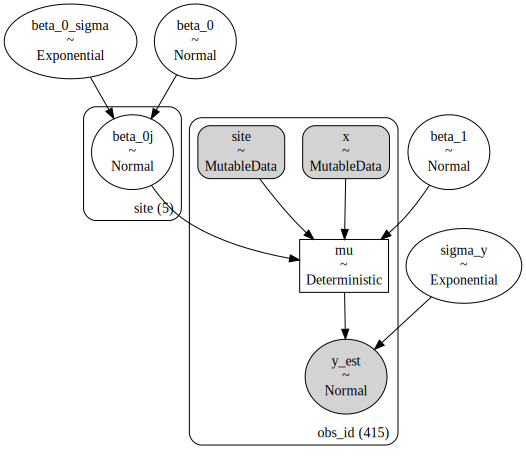

In [20]:
pm.model_to_graphviz(var_inter_model_centered)

In [21]:
var_inter_model, var_inter_trace = run_var_inter_model(non_centered = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, sigma_y, beta_0_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 427 seconds.


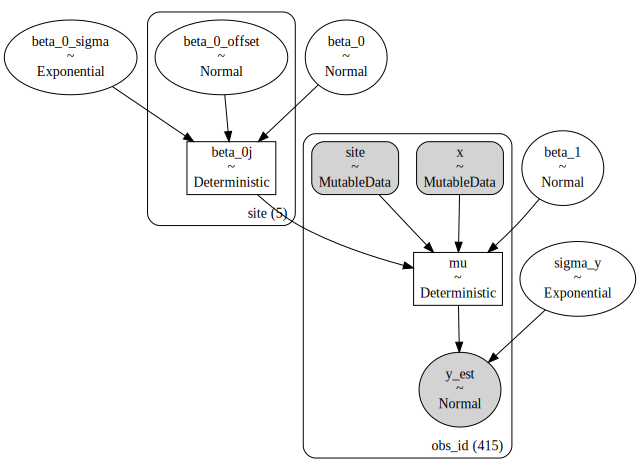

In [22]:
pm.model_to_graphviz(var_inter_model)

### 先验预测检查

In [23]:
var_inter_prior = pm.sample_prior_predictive(samples=50,
                                            model=var_inter_model,
                                            random_seed=84735)

Sampling: [beta_0, beta_0_offset, beta_0_sigma, beta_1, sigma_y, y_est]


In [24]:
# 定义绘制先验预测回归线的函数，其逻辑与绘制后验预测回归线相同
def plot_prior(prior,group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(df_first5["Site"].unique()), 
                        sharex=True,
                        sharey=True,
                        figsize=(20,5))
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据中的自变量，每一个因变量的先验预测均值
    # 这些数据都储存在先验预测采样结果中，也就是这里所用的prior
    for i, group in enumerate(df_first5["Site"].unique()): 
        #绘制回归线
        ax[i].plot(prior.constant_data["x"].sel(obs_id = group_index[f"{group}"]),
                prior.prior["mu"].sel(obs_id = group_index[f"{group}"]).stack(sample=("chain","draw")),
                c='gray',
                alpha=0.5)
        ax[i].set_title(f"{group}")
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Prior regression models", fontsize=15, y=1)
        
    sns.despine()

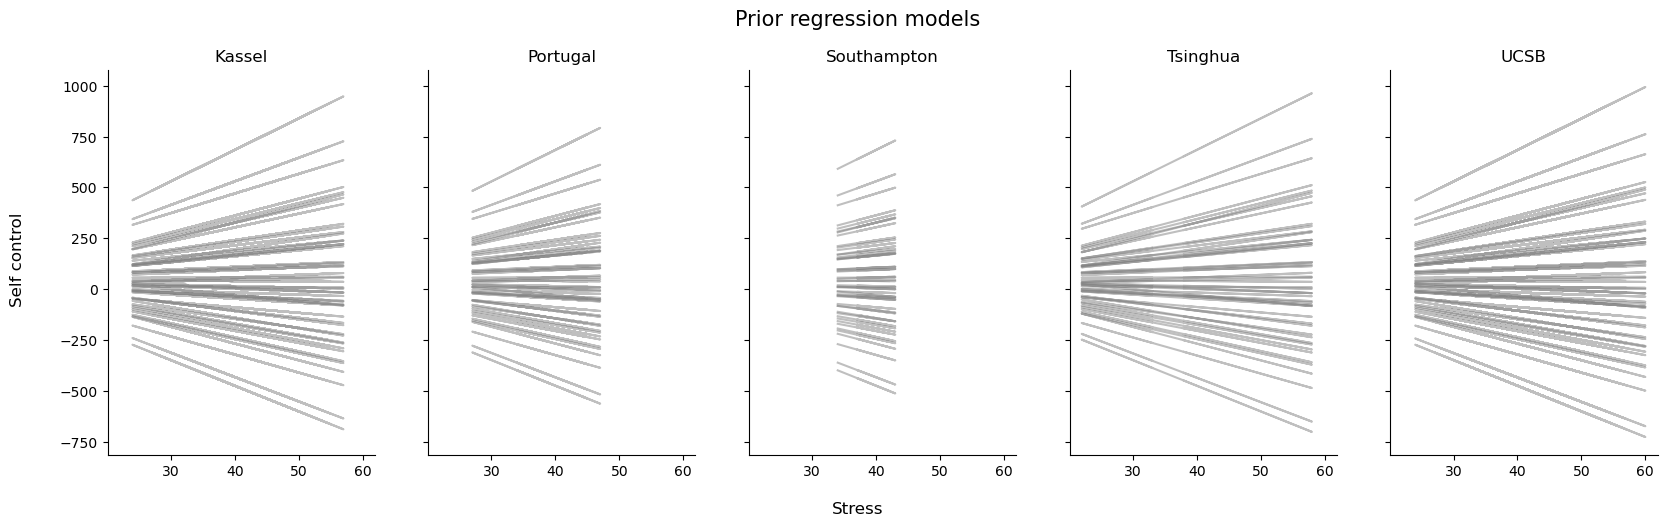

In [25]:
plot_prior(prior=var_inter_prior,
           group_index=first5_index)

###  MCMC采样&后验参数估计  

* 可以看到5条回归线的斜率都是一致的 $\beta_1 = -0.56$  
* 总体层面的解决 $\beta_0 = 63.15$  
* 但截距$\beta_{0j}$[xx]有所不同:  
    * $\beta_{0}$[Kassel] = 63.56  
    * $\beta_{0}$[Portugal] = 65.37  
    * $\beta_{0}$[Southampton] = 62.58  
    * $\beta_{0}$[Tsinghua] = 62.09  
    * $\beta_{0}$[UCSB] = 62.37

In [26]:
# ~ 和filter_vars="like" 表示在显示结果时去除掉包含这些字符的变量
var_inter_para = az.summary(var_inter_trace,
           var_names=["~mu","~_sigma","~_offset","~sigma_"],
           filter_vars="like")
var_inter_para

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,63.148,2.088,59.342,67.175,0.023,0.016,8390.0,11140.0,1.0
beta_1,-0.563,0.047,-0.651,-0.473,0.000,0.000,9881.0,12031.0,1.0
beta_0j[Kassel],63.556,1.967,59.869,67.292,0.019,0.014,10461.0,12406.0,1.0
beta_0j[Portugal],65.369,2.303,61.083,69.659,0.023,0.017,9717.0,12261.0,1.0
beta_0j[Southampton],62.578,2.400,58.065,67.057,0.023,0.016,10884.0,13666.0,1.0
beta_0j[Tsinghua],62.090,1.963,58.307,65.657,0.020,0.014,9767.0,12428.0,1.0
beta_0j[UCSB],62.371,2.063,58.530,66.219,0.021,0.015,9843.0,11940.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

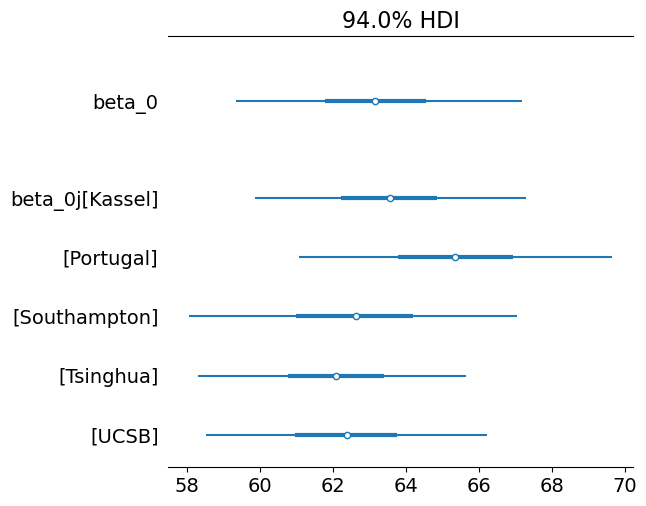

In [27]:
az.plot_forest(var_inter_trace,
           var_names=["~mu", "~sigma", "~offset", "~beta_1"],
           filter_vars="like",
           combined = True)

### 后验预测回归线  

* 5条回归线的截距不同，斜率相同

In [28]:
#定义函数，绘制不同站点下的后验预测回归线
def plot_partial_regression(data, trace, group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                       sharex=True,
                       sharey=True,
                       figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        #绘制真实数据的散点图
        x = trace.constant_data.x.sel(obs_id = group_index[f"{group}"])
        y = trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"])
        mu = trace.posterior.mu.sel(obs_id = group_index[f"{group}"])
        ax[i].scatter(x, y,
                color=f"C{i}",
                alpha=0.5)
        #绘制回归线
        ax[i].plot(x, mu.stack(sample=("chain","draw")).mean(dim="sample"),
                color=f"C{i}",
                alpha=0.5)
        ax[i].set_title(f"Intercept: {var_inter_para.loc[f'beta_0j[{group}]']['mean']}", fontsize=12)
        #绘制预测值95%HDI
        az.plot_hdi(
            x, mu,
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
        
    # 生成横坐标名称
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Posterior regression models(varing intercept)", fontsize=15, y=1.05)
        
    sns.despine()

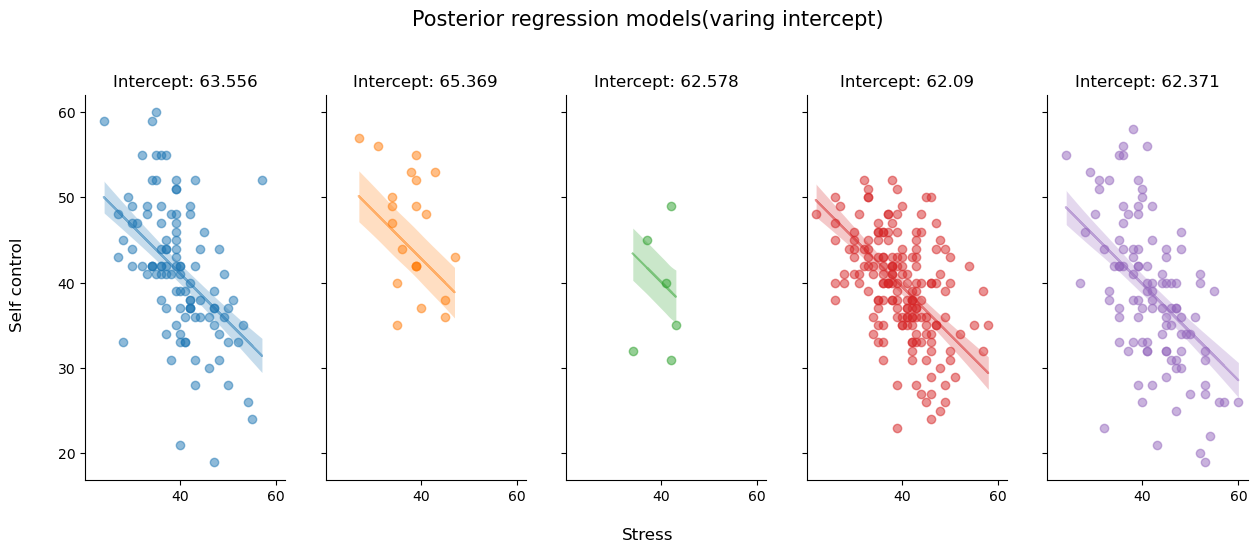

In [29]:
plot_partial_regression(data=df_first5,
                trace=var_inter_trace,
                group_index=first5_index)

### 组间方差与组内方差  

* 在这个模型定义中，组间方差来自`beta_0_offset`，组内方差来自`sigma_y`  
* 结果发现：组间变异 (0.067) 小于组内变异 (0.932)，表明组内相关性低。

In [30]:
# 提取组间和组内变异
para_sum = az.summary(var_inter_trace,
                      var_names=["_offset","sigma_"],
                      filter_vars="like")
between_sd = (para_sum.filter(like='_offset', axis=0)["mean"]**2).sum()
within_sd = para_sum.loc['sigma_y','mean']**2
# 计算变异占比
var = between_sd + within_sd
print("被组间方差所解释的部分：", between_sd/var)
print("被组内方差所解释的部分：", within_sd/var)
print("组内相关：",between_sd/var)


被组间方差所解释的部分： 0.06711151565666632
被组内方差所解释的部分： 0.9328884843433337
组内相关： 0.06711151565666632


## Model2: Hierarchical model with varying slopes  

* 上一个模型考虑了回归截距随站点的变化，在模型2中，我们假设不同站点间的回归截距保持不变，但回归斜率随站点变化。  

$$  
\beta_{1j} | \beta_1, \sigma_1 \sim N(\beta_1, \sigma_1^2)  
$$  

类似于模型1，**模型2的定义形式为：**  

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0}, \beta_{1j}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0} + \beta_{1j} X_{ij} & \text{(每个站点内的线性模型)} \\  
\beta_{1j} | \beta_1, \sigma_1  & \stackrel{ind}{\sim} N(\beta_1, \sigma_1^2)  & \text{(斜率在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_1 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$  

或：  

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0}, \beta_{1j}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0} + (\beta_{1} + b_{1j}) X_{ij} & \text{(每个站点内的线性模型)} \\  
b_{1j} | \sigma_1 & \stackrel{ind}{\sim} N(0, \sigma_1^2) & \text{(斜率在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_1 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$

In [31]:
# 定义函数来构建和采样模型
def run_var_slope_model(non_centered = False):

    #定义数据坐标，包括站点和观测索引
    coords = {"site": df_first5["Site"].unique(),
            "obs_id": df_first5.obs_id}

    with pm.Model(coords=coords) as model:
        #定义全局参数
        beta_0 = pm.Normal("beta_0", mu=0, sigma=50)
        beta_1 = pm.Normal("beta_1", mu=0, sigma=5) 
        beta_1_sigma = pm.Exponential("beta_1_sigma", 1)
        sigma_y = pm.Exponential("sigma_y", 1) 

        #传入自变量、获得观测值对应的站点映射
        x = pm.MutableData("x", df_first5.stress, dims="obs_id")
        site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

        #选择不同的模型定义方式
        if non_centered:
            beta_1_offset = pm.Normal("beta_1_offset", 0, sigma=1, dims="site")
            beta_1j = pm.Deterministic("beta_1j", beta_1 + beta_1_offset * beta_1_sigma, dims="site")
        else:
            beta_1j = pm.Normal("beta_1j", mu=beta_1, sigma=beta_1_sigma, dims="site")

        #线性关系
        mu = pm.Deterministic("mu", beta_0+beta_1j[site]*x, dims="obs_id")

        # 定义 likelihood
        likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

        trace = pm.sample(draws=5000,           # 使用mcmc方法进行采样，draws为采样次数
                            tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                            chains=4,                     # 链数
                            discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                            random_seed=84735,
                            target_accept=0.99)
    
    return model, trace

In [32]:
# 注意，以下代码可能运行5分钟左右

var_slope_model, var_slope_trace = run_var_slope_model(non_centered = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_1_sigma, sigma_y, beta_1_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 521 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


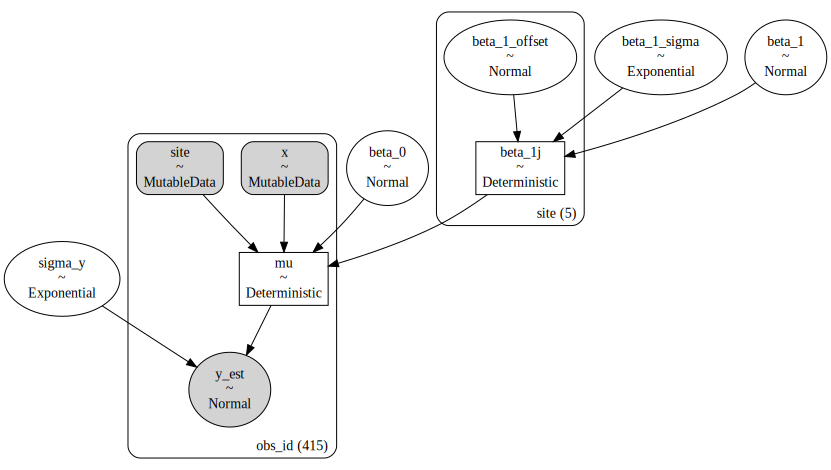

In [33]:
pm.model_to_graphviz(var_slope_model)

###  MCMC采样&后验参数估计  

* 可以看到5条回归线的截距 $\beta_{0j}$ 一致，但是斜率$\beta_{1j}$ 不同  
* $\beta_{1j}$ 在总体$\beta_{1}$ 上增加了变异

In [34]:
var_slope_para = az.summary(var_slope_trace,
                            var_names=["beta_0","beta_1j"],
                            filter_vars="like")
var_slope_para 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,62.546,1.938,58.808,66.073,0.018,0.013,11179.0,11361.0,1.0
beta_1j[Kassel],-0.538,0.050,-0.634,-0.444,0.000,0.000,11477.0,12204.0,1.0
beta_1j[Portugal],-0.468,0.065,-0.595,-0.349,0.001,0.001,8358.0,10441.0,1.0
beta_1j[Southampton],-0.570,0.069,-0.701,-0.442,0.001,0.000,12400.0,13063.0,1.0
beta_1j[Tsinghua],-0.573,0.049,-0.666,-0.483,0.000,0.000,11677.0,12129.0,1.0
beta_1j[UCSB],-0.573,0.047,-0.660,-0.484,0.000,0.000,11965.0,12268.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

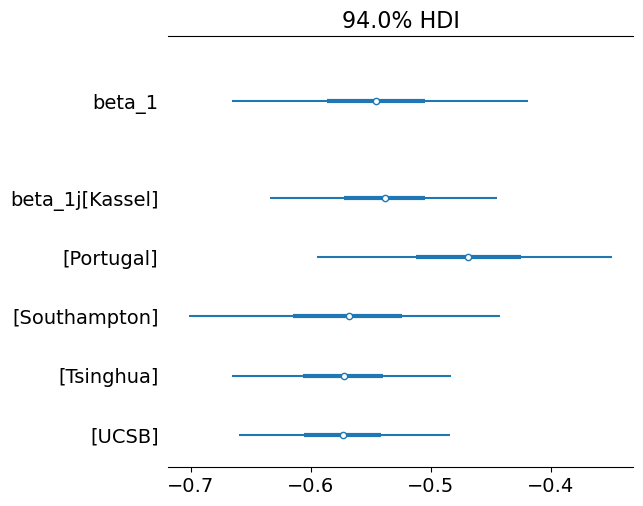

In [35]:
az.plot_forest(var_slope_trace,
           var_names=["~mu", "~sigma", "~offset", "~beta_0"],
           filter_vars="like",
           combined = True)

### 后验预测回归线  

* 5条回归线的截距相同，但是斜率不同

In [36]:
#定义函数，绘制不同站点下的后验预测回归线
def plot_partial_regression(data, trace, group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                       sharex=True,
                       sharey=True,
                       figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        #绘制真实数据的散点图
        x = trace.constant_data.x.sel(obs_id = group_index[f"{group}"])
        y = trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"])
        mu = trace.posterior.mu.sel(obs_id = group_index[f"{group}"])
        ax[i].scatter(x, y,
                color=f"C{i}",
                alpha=0.5)
        #绘制回归线
        ax[i].plot(x, mu.stack(sample=("chain","draw")).mean(dim="sample"),
                color=f"C{i}",
                alpha=0.5)
        ax[i].set_title(f"Slope: {var_slope_para.loc[f'beta_1j[{group}]']['mean']}", fontsize=12)
        #绘制预测值95%HDI
        az.plot_hdi(
            x, mu,
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
        
    # 生成横坐标名称
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Posterior regression models(varing slope)", fontsize=15, y=1.05)
        
    sns.despine()

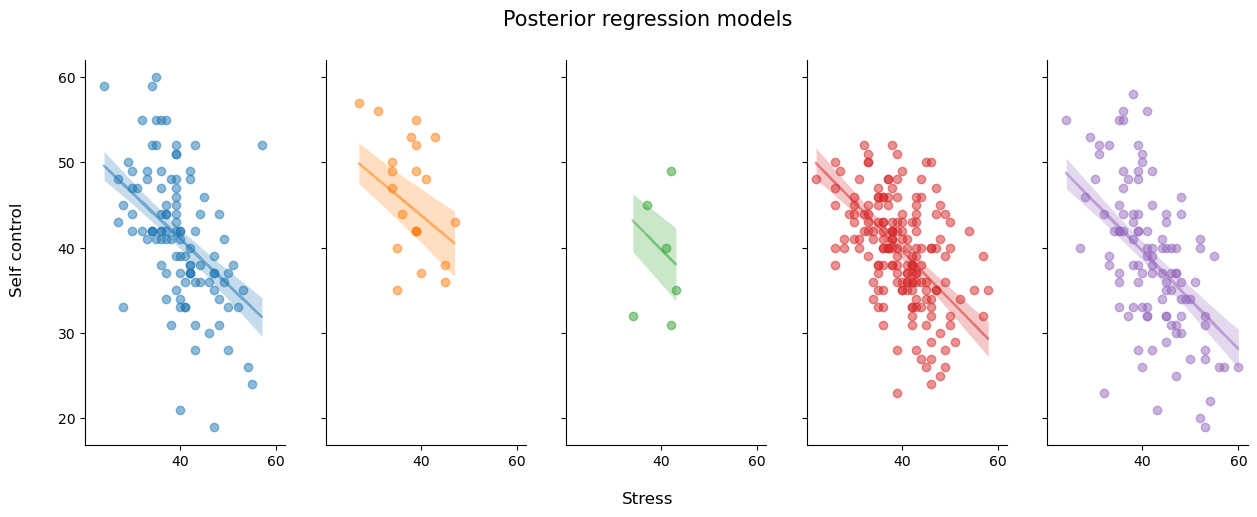

In [37]:
plot_regression(data=df_first5,
                trace=var_slope_trace,
                group_index=first5_index)

### 组间方差与组内方差  

* 在这个模型定义中，组间方差来自`beta_1_offset`，组内方差来自`sigma_y`

In [38]:
# 提取组间和组内变异
para_sum = az.summary(var_slope_trace,
                      var_names=["_offset","sigma_"],
                      filter_vars="like")
between_sd = (para_sum.filter(like='_offset', axis=0)["mean"]**2).sum()
within_sd = para_sum.loc['sigma_y','mean']**2
# 计算变异占比
var = between_sd + within_sd
print("被组间方差所解释的部分：", between_sd/var)
print("被组内方差所解释的部分：", within_sd/var)
print("组内相关：",between_sd/var)

被组间方差所解释的部分： 0.04576349208805919
被组内方差所解释的部分： 0.9542365079119408
组内相关： 0.04576349208805919


## Model3: Hierarchical model with varying intercepts & slopes  

模型1 和模型2分别考虑了截距和斜率随着站点的变化，在模型3中我们将同时考虑截距和斜率在不同站点间的差异  

$$  
\beta_{0j} | \beta_0, \sigma_0 \sim N(\beta_0, \sigma_0^2)  
\;\;\;\; \text{ and } \;\;\;\;  
\beta_{1j} | \beta_1, \sigma_1 \sim N(\beta_1, \sigma_1^2)  
$$  

**总结模型定义：**  

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0j}, \beta_{1j}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_{1j} X_{ij} & \text{(每个站点内的线性模型)} \\  
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\  
\beta_{1j} | \beta_1, \sigma_1  & \stackrel{ind}{\sim} N(\beta_1, \sigma_1^2) & \text{(斜率在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_0 & \sim \text{Exp}(1)    & \\  
\sigma_1 & \sim \text{Exp}(1)    & \\  
\sigma_y & \sim \text{Exp}(1).    & \\  
\end{array}  
$$  

或：  
$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0}, \beta_{1j}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = (\beta_{0} +b_{0j}) + (\beta_{1} + b_{1j}) X_{ij} & \text{(每个站点内的线性模型)} \\  
b_{0j} | \sigma_0 & \stackrel{ind}{\sim} N(0, \sigma_0^2) & \text{(截距在站点间的变化)} \\  
b_{1j} | \sigma_1 & \stackrel{ind}{\sim} N(0, \sigma_1^2) & \text{(斜率在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_0 & \sim \text{Exp}(1)    & \\  
\sigma_1 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$  


**分层模型与非池化模型的对比**  

$$  
\beta_0 \sim N(0, 50)\\  
\sigma_0 \sim \text{Exp}(1)\\  
\beta_1 \sim N(0,5)\\  
\sigma_1 \sim \text{Exp}(1)  
$$  

* 在非池化模型中，我们认为截距、斜率和变异在不同站点间是不同的；  
* 但在层级模型中，我们仍考虑了来自总体的的信息，即不同站点间的斜率/截距仍是从总体斜率/截距中抽样的。  
	* 注意，在层级模型中一般不会假设*变异会随着分组变量变化*，这也是分层模型和非池化模型的重要区别。  


In [39]:
# 定义函数来构建和采样模型
def run_var_both_model(non_centered = False):

    #定义数据坐标，包括站点和观测索引
    coords = {"site": df_first5["Site"].unique(),
            "obs_id": df_first5.obs_id}

    with pm.Model(coords=coords) as model:
        #定义全局参数
        beta_0 = pm.Normal("beta_0", mu=0, sigma=50)
        beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
        beta_1 = pm.Normal("beta_1", mu=0, sigma=5) 
        beta_1_sigma = pm.Exponential("beta_1_sigma", 1)
        sigma_y = pm.Exponential("sigma_y", 1) 

        #传入自变量、获得观测值对应的站点映射
        x = pm.MutableData("x", df_first5.stress, dims="obs_id")
        site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

        #选择不同的模型定义方式
        if non_centered:
            beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
            beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
            beta_1_offset = pm.Normal("beta_1_offset", 0, sigma=1, dims="site")
            beta_1j = pm.Deterministic("beta_1j", beta_1 + beta_1_offset * beta_1_sigma, dims="site")
        else:
            beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")
            beta_1j = pm.Normal("beta_1j", mu=beta_1, sigma=beta_1_sigma, dims="site")

        #线性关系
        mu = pm.Deterministic("mu", beta_0j[site]+beta_1j[site]*x, dims="obs_id")

        # 定义 likelihood
        likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

        trace = pm.sample(draws=5000,           # 使用mcmc方法进行采样，draws为采样次数
                            tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                            chains=4,                     # 链数
                            discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                            random_seed=84735,
                            target_accept=0.99)
    
    return model, trace

In [40]:
# 注意，以下代码可能运行10分钟左右

var_both_model, var_both_trace = run_var_both_model(non_centered = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, beta_1_sigma, sigma_y, beta_0_offset, beta_1_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 756 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


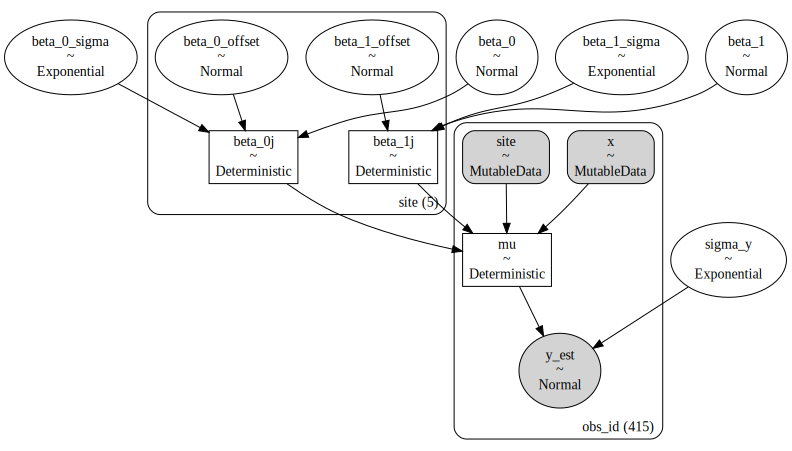

In [41]:
pm.model_to_graphviz(var_both_model)

###  MCMC采样&后验参数估计  

* 可以看到5条回归线的斜率$\beta_{1j}$、截距$\beta_{0j}$都是不同的  
* $\beta_{1j}$、$\beta_{0j}$是在总体$\beta_{1}$、$\beta_{0}$上增加了一些变异

In [42]:
var_both_para = az.summary(var_both_trace,
                            var_names=["beta_0j","beta_1j"],
                            filter_vars="like")
var_both_para

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0j[Kassel],63.196,2.183,59.089,67.310,0.018,0.013,15240.0,14356.0,1.0
beta_0j[Portugal],63.834,2.614,58.942,68.823,0.025,0.018,10713.0,14140.0,1.0
beta_0j[Southampton],62.540,2.447,57.957,67.204,0.019,0.014,16504.0,14685.0,1.0
beta_0j[Tsinghua],61.805,2.181,57.840,66.005,0.017,0.012,16068.0,14420.0,1.0
beta_0j[UCSB],63.012,2.219,58.887,67.212,0.018,0.013,15577.0,14628.0,1.0
beta_1j[Kassel],-0.553,0.055,-0.660,-0.453,0.000,0.000,15289.0,14237.0,1.0
beta_1j[Portugal],-0.497,0.074,-0.634,-0.357,0.001,0.001,9691.0,14432.0,1.0
beta_1j[Southampton],-0.571,0.069,-0.700,-0.439,0.001,0.000,17665.0,15307.0,1.0
beta_1j[Tsinghua],-0.556,0.054,-0.658,-0.456,0.000,0.000,16480.0,14757.0,1.0
beta_1j[UCSB],-0.584,0.053,-0.685,-0.485,0.000,0.000,15349.0,14867.0,1.0


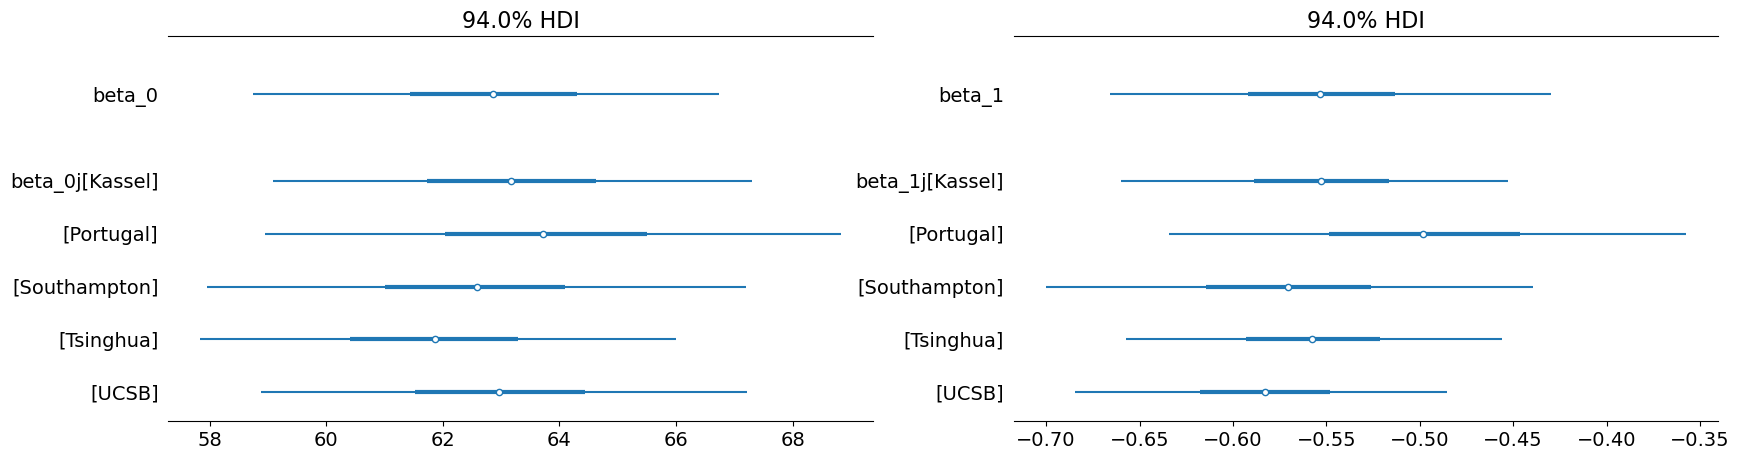

In [43]:
# 设置绘图坐标
figs, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
# 绘制变化的截距
az.plot_forest(var_both_trace,
           var_names=["~mu", "~sigma", "~offset", "~beta_1"],
           filter_vars="like",
           combined = True,
           ax=ax1)
# 绘制变化的斜率
az.plot_forest(var_both_trace,
           var_names=["~mu", "~sigma", "~offset", "~beta_0"],
           filter_vars="like",
           combined = True,
           ax=ax2)
plt.show()

### 后验预测回归线  
* 5条回归线的截距、斜率都是不同的

In [44]:
#定义函数，绘制不同站点下的后验预测回归线
def plot_partial_regression(data, trace, group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                       sharex=True,
                       sharey=True,
                       figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        #绘制真实数据的散点图
        x = trace.constant_data.x.sel(obs_id = group_index[f"{group}"])
        y = trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"])
        mu = trace.posterior.mu.sel(obs_id = group_index[f"{group}"])
        ax[i].scatter(x, y,
                color=f"C{i}",
                alpha=0.5)
        #绘制回归线
        ax[i].plot(x, mu.stack(sample=("chain","draw")).mean(dim="sample"),
                color=f"C{i}",
                alpha=0.5)
        ax[i].set_title(f"Slope: {var_both_para.loc[f'beta_1j[{group}]']['mean']}\nIntercept: {var_both_para.loc[f'beta_0j[{group}]']['mean']}", 
        fontsize=12)
        #绘制预测值95%HDI
        az.plot_hdi(
            x, mu,
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
        
    # 生成横坐标名称
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Posterior regression models(varing slope and intercept)", fontsize=15, y=1.05)
        
    sns.despine()




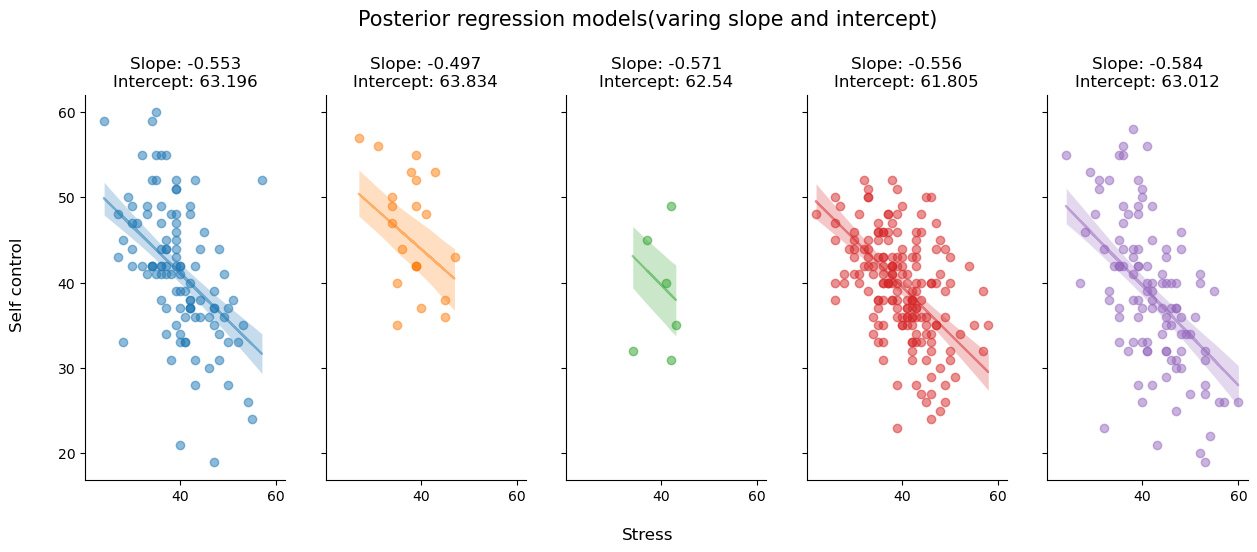

In [45]:
plot_partial_regression(data=df_first5,
                trace=var_both_trace,
                group_index=first5_index)

### 组间方差与组内方差  

* 在这个模型定义中，组间方差来自`beta_0_offset`、`beta_1_offset`，组内方差来自`sigma_y`

In [46]:
# 提取组间和组内变异
para_sum = az.summary(var_both_trace,
                      var_names=["_offset","sigma_"],
                      filter_vars="like")
between_sd = (para_sum.filter(like='_offset', axis=0)["mean"]**2).sum()
within_sd = para_sum.loc['sigma_y','mean']**2
# 计算变异占比
var = between_sd + within_sd
print("被组间方差所解释的部分：", between_sd/var)
print("被组内方差所解释的部分：", within_sd/var)
print("组内相关：",between_sd/var)


被组间方差所解释的部分： 0.04697400539307276
被组内方差所解释的部分： 0.9530259946069272
组内相关： 0.04697400539307276


## 评估后验预测

In [47]:
complete_ppc = pm.sample_posterior_predictive(complete_trace, 
                                            model = complete_pooled_model,
                                            random_seed=84735)
no_ppc = pm.sample_posterior_predictive(no_trace, 
                                        model = complete_pooled_model,
                                        random_seed=84735)   
var_inter_ppc = pm.sample_posterior_predictive(var_inter_trace,
                                                model = var_inter_model,
                                                random_seed=84735)
var_slope_ppc = pm.sample_posterior_predictive(var_slope_trace,
                                                model = var_slope_model,
                                                random_seed=84735)                                                                                       
var_both_ppc = pm.sample_posterior_predictive(var_both_trace, 
                                            model = var_both_model,
                                            random_seed=84735)

Sampling: [y_est]


Sampling: [y_est]


TypeError: ('Wrong number of dimensions: expected 0, got 1 with shape (5,).', 'Container name "beta_0"')

In [ ]:
# 定义计算 MAE 函数
from statistics import median
def MAE(model_ppc):
    # 计算每个X取值下对应的后验预测模型的均值
    pre_x = model_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_x.mean(axis=1).values

    # 提取观测值Y，提取对应Y值下的后验预测模型的均值
    MAE = pd.DataFrame({
        "scontrol_ppc_mean": pre_y_mean,
        "scontrol_original": df.scontrol
    })

    # 计算预测误差
    MAE["pre_error"] = abs(MAE["scontrol_original"] -\
                            MAE["scontrol_ppc_mean"])

    # 最后，计算预测误差的中位数
    MAE = median(MAE.pre_error)
    return MAE


In [ ]:
# 定义
def counter_outlier(model_ppc, hdi_prob=0.95):
    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi = az.summary(model_ppc, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    # 将原数据中的自我控制分数合并，便于后续进行判断
    y_obs = model_ppc.observed_data["y_est"].values

    # 判断原数据中的压力分数是否在后验预测的95%可信区间内，并计数
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num

# 输出结果
model0_outliers = counter_outlier(complete_ppc)
print(f"模型1(完全池化)超出95%hdi: {model0_outliers:.2f}")
model1_outliers = counter_outlier(no_ppc)
print(f"模型2(部分池化)超出95%hdi: {model1_outliers:.2f}")
model2_outliers = counter_outlier(var_inter_ppc)
print(f"模型3(变化截距)超出95%hdi: {model2_outliers:.2f}")
model3_outliers = counter_outlier(var_slope_ppc)
print(f"模型4(变化斜率)超出95%hdi: {model3_outliers:.2f}")
model4_outliers = counter_outlier(var_both_ppc)
print(f"模型5(变化截距、斜率)超出95%hdi: {model4_outliers:.2f}")


In [ ]:
pm.xx

## Model comparison  

从模型比较的结果，我们可以发现：  
* 同时包含变化截距和变化斜率的模型(model3)是最优模型，对应了我们的假设3。  
* 值得注意的是，非池化模型 (no pool model)同样考虑了不同站点间截距和斜率的变化，但是它仅比完全池化模型好一些。  
* 此外，所有模型的 elpd 都非常接近 (考虑到 se大于为15~16)，因此，模型比较的结果只能作为参考，更重要的是通过后验预测检验模型的性能。  

模型假设：  
* H0(model 0)，普通线性模型，仅考虑压力对自我控制的影响。  
* H1(model 1)，变化截距模型，在模型0的基础上考虑自我控制在不同站点的变化。  
* H2(model 2)，变化斜率模型，在模型0的基础上不同站点间的压力影响的变化。  
* H3(model 3)，变化截距和斜率模型，结合模型1和模型2，同时考虑站点对自我控制以及压力影响的变化。

In [ ]:
pm.compute_log_likelihood(complete_trace, model=complete_pooled_model)
pm.compute_log_likelihood(no_trace, model=no_pooled_model)
pm.compute_log_likelihood(var_inter_trace, model=var_inter_model)
pm.compute_log_likelihood(var_slope_trace, model=var_slope_model)
pm.compute_log_likelihood(var_both_trace, model=var_both_model)

In [ ]:
comparison_list = {
    "model0(complete pool)":complete_trace,
    "model1(hierarchical intercept)":var_inter_trace,
    "model2(hierarchical slope)":var_slope_trace,
    "model3(hierarchy both)":var_both_trace,
    "no pool model":no_trace
}
az.compare(comparison_list)

## 预测新站点的数据  

* 我们可以根据当前的层级模型对新组别的数据进行预测，如"Zurich"站点  

* 在pymc中，只要在`pm.sample_posterior_predictive`中传入模型MCMC后验参数采样结果，即可以在该模型的基础上对新数据生成预测  

* 预测结果储存在`.predictions`中

In [ ]:
# 选择站点为"Zurich"的数据
new_group = df_raw[df_raw.Site=="Zurich"]
# 生成被试索引
new_group["obs_id"] = range(len(new_group))
# 生成站点索引
new_group["site_idx"] = pd.factorize(new_group.Site)[0]

In [ ]:
new_coords = {"site": new_group["Site"].unique(),
          "obs_id": new_group.obs_id}

with pm.Model(coords=new_coords) as hier_pred:
    #定义全局参数(这部分没有改变)
    beta_0 = pm.Normal("beta_0", mu=40, sigma=20)
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5) 
    beta_1_sigma = pm.Exponential("beta_1_sigma", 1)
    sigma_y = pm.Exponential("sigma_y", 1) 

    #传入自变量
    x = pm.MutableData("x", new_group.stress, dims="obs_id")
    #获得观测值对应的站点映射
    site = pm.MutableData("site", new_group.site_idx, dims="obs_id") 
    
    #注意：在这里我们需要传入一个新的参数名，因为传入的是一个新站点(除此处外，其余的定义变量名未发生改变)
    new_beta_0_offset = pm.Normal("new_beta_0_offset", 0, sigma=1, dims="site")
    new_beta_0j = pm.Deterministic("new_beta_0j", beta_0 + new_beta_0_offset * beta_0_sigma, dims="site")
    new_beta_1_offset = pm.Normal("new_beta_1_offset", 0, sigma=1, dims="site")
    new_beta_1j = pm.Deterministic("new_beta_1j", beta_1 + new_beta_1_offset * beta_1_sigma, dims="site")
    new_mu = pm.Normal("new_mu",  new_beta_0j[site]+new_beta_1j[site]*x, dims="obs_id")

    #似然
    likelihood = pm.Normal("y_est", mu=new_mu, sigma=sigma_y, observed=new_group.scontrol, dims="obs_id")

    # 进行后验预测估计，注意使用的是上一个模型的后验参数估计，partial_trace
    pred_trace = pm.sample_posterior_predictive(var_both_trace,
                                                var_names=["new_mu","y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

In [ ]:
pred_trace

#### 后验预测回归线

In [ ]:
plt.scatter(new_group["stress"],
            new_group["scontrol"],
            alpha=0.5,
            color="C1")
#绘制回归线
plt.plot(pred_trace.predictions_constant_data.x,
        pred_trace.predictions.new_mu.stack(sample=("chain","draw")).mean(dim="sample"),
        alpha=0.5,
        color="C1")
#绘制预测值95%HDI
az.plot_hdi(
        pred_trace.predictions_constant_data.x,
        pred_trace.predictions.new_mu,
        hdi_prob=0.95,
        fill_kwargs={"color":"C1",
            "alpha": 0.25, "linewidth": 0})
 # 生成横坐标名称
plt.xlabel('Stress',fontsize=12)
# 生成纵坐标名称
plt.ylabel('Self control',fontsize=12)
# 生成标题
plt.suptitle("Posterior regression models", fontsize=15)
        
sns.despine()

## bambi code  

* bambi在对层级模型进行定义时，它认为组间参数如截距/斜率，由共同部分和组间变异组成(即pymc中的non-centered定义)  

| 模型  | 模型表达    |  
| -------- | ----------|  
| complete_pool |"scontrol ~ stress" |  
| no pool | "scontrol ~ "0 + stress:Site" |  
| varing intercepts | "scontrol ~ stress + (1\|Site)" |  
| varing slopes  | "scontrol ~ stress + (0 + stress\|Site)" |  
| varing intercepts and slopes  |"scontrol ~ 1 + stress + (1 + stress\|Site)"  |  

* 在bambi中，1表示添加回归截距，0表示不添加回归截距。  
* (...|Site)表示分层模型  
	* (1|Site)表示：仅包含截距的组间变异  
	* (0 + stress|Site)表示: 仅包含斜率的组间变异  
	* (1 + stress|Site)表示: 包含截距和斜率的组间变异，可以写作 (stress|Site)  
* 注意，bambi 中无法定义真正的非池化模型  
	* "scontrol ~ "0 + stress:Site"仅假设斜率存在变异，并且各站点的斜率相互独立。  
	* 因此，之后我们仅考虑用 bambi 来定义分层模型，而不是非池化的模型。

In [ ]:
# complete-pooled
complete_bmb = bmb.Model("scontrol ~ stress",
                         df_first5,
                         family="gaussian")
complete_bmb.build()
complete_bmb.graph()

In [ ]:
# no-pooled
no_bmb = bmb.Model("scontrol ~ 0 + stress:Site",
                      df_first5)
no_bmb.build()
no_bmb.graph()

In [ ]:
# group-specific intercepts
inter_bmb = bmb.Model("scontrol ~ stress + (1|Site)",
                      df_first5,
                      categorical="Site")

inter_bmb.build()
inter_bmb.graph()

In [ ]:
# group-specific slopes
slope_bmb = bmb.Model("scontrol ~ stress + (0 + stress|Site)",
                      df_first5,
                      categorical="Site")
slope_bmb.build()
slope_bmb.graph()

In [ ]:
# group specific intercept and slope
var_both_bmb = bmb.Model("scontrol ~ 1 + stress + (stress|Site)",
                         df_first5,
                         categorical="Site")

var_both_bmb.build()
var_both_bmb.graph()

## Hierarchical logistic regression

> 在之前的课程中，除了正态回归模型，我们还介绍过logistic回归模型、泊松回归模型和负二项回归模型。这些模型同样可以和层级模型结合  

* 在lec13中我们使用回避依恋分数来预测个体的恋爱情况，假设这一线性关系在不同文化中有不同的表现，我们也可以把站点信息考虑在内  

* 对于因变量为离散变量的情况，我们需要使用广义线性模型(Generalized linear model，GLM)。  

* 其特点为：  
	- 分布簇 (dist)不再局限于正态分布，而是允许其他不同的分布，比如 $y \sim Bernoulli(p)$  
	- 需要 **链接函数$g()$** 将 $\alpha + \beta * x$  映射到 $p$所在的范围  

| 一般线性模型 | 广义线性模型 |  
|---|---|  
| $y \sim Normal(\mu, \sigma)$ | $y \sim dist(p)$ |  
| $\mu = \alpha + \beta *x$ | $p = g(z)$|  
|  | $z = \alpha + \beta *x$|  


In [ ]:
#查看所需列中是否存在缺失值
df_first5[df_first5[["romantic", "avoidance_r"]].isna().any(axis=1)]

In [ ]:
#删除缺失值
df_first5.dropna(subset=["romantic", "avoidance_r"], inplace=True)
#再次查看所需列中是否存在缺失值
df_first5[df_first5["romantic"].isna()]

In [ ]:
#对数据进行重新编码
df_first5["romantic"] =  np.where(df_first5['romantic'] == 2, 0, 1)

In [ ]:
# 创建画图所需的网格数
g = sns.FacetGrid(df_first5, col="Site", col_wrap=5, height=4)

# 将各个图所画的内容对应到画布上
g.map(sns.regplot, "avoidance_r", "romantic")

# 调整y轴的刻度
plt.ylim(-0.5,1.5)
plt.yticks([0,1])
# Show the plot
plt.show()

### 完全池化模型  

#### 模型定义  

在这里，对完全池化模型的定义，和我们在lec13中介绍过的logistic回归模型是一样的  

对先前介绍过的模型定义进行回顾：  

* 因变量恋爱情况为二分变量  

$$  
Y_{ij} = \begin{cases}  
1 & \text{yes} \\  
0 & \text{no} \\  
\end{cases}  
$$  

* 恋爱情况与回避依恋分数的情况可以表示为：  
$$  
\begin{split}  
Y_{ij}|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_{ij}) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{ij}}}{1 + e^{\beta_0 + \beta_1 X_{ij}}}  \\  
\beta_{0}  &  \sim N\left(0, 0.5^2 \right)  \\  
\beta_1  &  \sim N\left(0, 0.5^2 \right)   \\  
\end{split}  
$$  

* 注意对$\beta_0,\beta_1$在整体logistic回归中的意义，在这里仅简单解释为线性关系中的斜率和截距  

> 注：在代码的模型定义中，我们使用的是bambi默认的先验，此处先验定义中的具体数值只为辅助说明使用。

#### MCMC采样&后验参数估计

In [ ]:
complete_logit_bmb = bmb.Model("romantic ~ avoidance_r", 
                               df_first5, 
                               family="bernoulli")
complete_logit_trace = complete_logit_bmb.fit(random_seed=84735)

**后验参数解释**  

* `avoidance_r`为共同的斜率  

* `Intercept`为共同的截距  


In [ ]:
az.summary(complete_logit_trace)

### 变化截距模型  

#### 模型定义  

* 考虑线性关系(截距)在不同站点间的不同  

$$  
\begin{array}{rll}  
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0j} + \beta_{1} X_{ij}}}{1 + e^{\beta_{0j} + \beta_{1} X_{ij}}} \\  
&& \text{(每个站点 $j$内的线性模型)}\\  

\beta_{0j} &= \beta_0 + b_{0j}\;\;\;b_{0j} \sim N(0, \sigma_0^2)& \text{(截距在站点间的变化)} \\  

\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\  
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\  
\sigma_0 & \sim \text{Exp}(1) & \\  
\end{array}  

$$  

* 模型图中的`Intercept`即为$\beta_{0}$，`1|Site`即为$b_{0j}$

In [ ]:
# common slope/ common intercept + group-specific intercept
inter_logit_bmb = bmb.Model("romantic ~ avoidance_r + (1|Site)",
                               df_first5,
                               family="bernoulli")
inter_logit_bmb.build()
inter_logit_bmb.graph()

#### MCMC采样&后验参数估计

In [ ]:
inter_logit_trace = inter_logit_bmb.fit(draws=5000,           
                                    tune=1000,                    
                                    chains=4,                     
                                    discard_tuned_samples= True,  
                                    random_seed=84735,
                                    target_accept=0.99)

**后验参数解释**  

* `avoidance_r`为共同的斜率  

* `Intercept`为共同的截距  

* `1|Site[xx]`为每一组在截距上的变异  

    * 如，Kassel站点的截距为：0.250+0.336 = 0.586

In [ ]:
az.summary(inter_logit_trace)

### 变化斜率模型  

#### 模型定义  

* 考虑线性关系(斜率)在不同站点间的不同  

$$  
\begin{array}{rll}  
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0} + \beta_{1j} X_{ij}}}{1 + e^{\beta_{0} + \beta_{1j} X_{ij}}} \\  
&& \text{(每个站点 $j$内的线性模型)}\\  
\beta_{1j} &= \beta_1 + b_{1j}\;\;\;b_{1j} \sim N(0, \sigma_1^2)& \text{(斜率在站点间的变化)} \\  

\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\  
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\  
\sigma_1 & \sim \text{Exp}(1) & \\  
\end{array}  

$$

In [ ]:
# common slope +group-specific slope/ common intercept + group-specific intercept
slope_logit_bmb = bmb.Model("romantic ~ avoidance_r + (0 + avoidance_r|Site)",
                               df_first5,
                               family="bernoulli")
slope_logit_bmb.build()
slope_logit_bmb.graph()

#### MCMC采样&后验参数估计

In [ ]:
slope_logit_trace = slope_logit_bmb.fit(draws=5000,           
                                    tune=1000,                    
                                    chains=4,                     
                                    discard_tuned_samples= True,  
                                    random_seed=84735,
                                    target_accept=0.99)

**后验参数解释**  

* `Intercept`为共同的截距  

* `avoidance_r`为共同的斜率  

* `avoidance_r|Site[xx]`为每一组在斜率上的变异  

    * 如，Kassel站点的斜率为：0.003+0.036 = 0.039

In [ ]:
az.summary(slope_logit_trace)

### 变化斜率、截距模型  

#### 模型定义  

* 考虑线性关系在不同站点间的不同  

$$  
\begin{array}{rll}  
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0j} + \beta_{1j} X_{ij}}}{1 + e^{\beta_{0j} + \beta_{1j} X_{ij}}} \\  
&& \text{(每个站点 $j$内的线性模型)}\\  

\beta_{0j} &= \beta_0 + b_{0j}\;\;\;b_{0j} \sim N(0, \sigma_0^2)& \text{(截距在站点间的变化)} \\  

\beta_{1j} &= \beta_1 + b_{1j}\;\;\;b_{1j} \sim N(0, \sigma_1^2)& \text{(斜率在站点间的变化)} \\  

\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\  
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\  
\sigma_0 & \sim \text{Exp}(1) & \\  
\sigma_1 & \sim \text{Exp}(1) & \\  
\end{array}  

$$

In [ ]:
# common slope +group-specific slope/ common intercept + group-specific intercept
both_logit_bmb = bmb.Model("romantic ~ avoidance_r + (avoidance_r|Site)",
                               df_first5,
                               family="bernoulli")
both_logit_bmb.build()
both_logit_bmb.graph()

#### MCMC采样&后验参数解释

In [ ]:
both_logit_trace = both_logit_bmb.fit(draws=5000,           
                                    tune=1000,                    
                                    chains=4,                     
                                    discard_tuned_samples= True,  
                                    random_seed=84735,
                                    target_accept=0.99)

In [ ]:
both_logit_trace

In [ ]:
az.plot_trace(both_logit_trace,
              var_names=["~sigma"],
              filter_vars="like",
              figsize=(12, 15))
plt.show()

**后验参数解释**  

* `Intercept`为共同的截距  

* `avoidance_r`为共同的斜率  

* `1|Site[xx]`为每一组在截距上的变异  

* `avoidance_r|Site[xx]`为每一组在斜率上的变异  

    * Kassel站点的斜率为：0.008 + 0.036 = 0.044  

    * Kassel站点的截距为：0.239 + 0.350 = 0.589

In [ ]:
az.summary(both_logit_trace)

#### 后验预测分布

In [ ]:
posterior_predictive = both_logit_bmb.predict(both_logit_trace, kind="pps")

In [ ]:
az.plot_ppc(both_logit_trace,
            num_pp_samples=500)

### 预测新站点的数据  

* 使用`.predict`，传入模型的MCMC采样结果和新的数据集，就可以在原有模型的基础上对新数据进行预测

In [ ]:
# 选择站点为"Zurich"的数据
new_group = df_raw[df_raw.Site=="Zurich"]
# 生成被试索引
new_group["obs_id"] = range(len(new_group))
# 生成站点索引
new_group["site_idx"] = pd.factorize(new_group.Site)[0]
# 删除缺失值
new_group.dropna(subset=["romantic", "avoidance_r"], inplace=True)
new_group[new_group["romantic"].isna()]
# 对数据进行重新编码
new_group["romantic"] =  np.where(new_group['romantic'] == 2, 0, 1)

In [ ]:
both_logit_bmb.predict(both_logit_trace,
                       kind="mean",
                       data=new_group,
                       sample_new_groups=True,
                       inplace=False)

### 补充：Pymc code for Hierarchical logistic regression  

* 在这里，我们补充对于完全池化模型与变化斜率&截距模型的 pymc 代码，可以自行学习

In [ ]:
coords = {"obs_id": df_first5.obs_id}
with pm.Model(coords=coords) as complete_log:
    #传入自变量与因变量
    x = pm.MutableData("x", df_first5.avoidance_r, dims="obs_id")
    y = pm.MutableData('y', df_first5.romantic, dims = 'obs_id')

    #先验
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1
    #线性关系
    mu = pm.Deterministic("mu", beta_0 + beta_1 * x, dims="obs_id")
    #注意此处使用了Logistic sigmoid function：pm.math.invlogit
    #相当于进行了如下计算 (1 / (1 + exp(-mu))
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

    complete_log_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                            tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                            chains=4,                     # 链数
                            discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                            random_seed=84735,
                            target_accept=0.99)

In [ ]:
#获得新数据集的索引
logit_index = get_group_index(data=df_first5)

In [ ]:
#绘图逻辑与上一个函数一样，只是此处使用logistic回归，绘制的变量需要更改
def plot_logit_regression(data,trace,group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                        sharex=True,
                        sharey=True,
                        figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        x = trace.constant_data.x.sel(obs_id = group_index[f"{group}"])
        #画出每个自变量对应的恋爱概率94%hdi值
        az.plot_hdi(
            x,
            trace.posterior.pi.sel(obs_id = group_index[f"{group}"]),
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
        
        #得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
        post_mean = trace.posterior.pi.sel(obs_id = group_index[f"{group}"]).mean(("chain", "draw"))
        ax[i].scatter(x=x,
                      y=post_mean,
                      color=f"C{i}",
                      alpha = 0.2)
        # sns.lineplot(x = x, 
        #             y= post_mean, 
        #             color=f"C{i}",
        #             ax=ax[i])
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        #绘制真实数据散点图
        ax[i].scatter(x,
                trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"]),
                color=f"C{i}",
                alpha=0.2)
    # 生成横坐标名称    
    fig.text(0.5, 0, 'Avoidance', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Romantic', ha='center', va='center', rotation='vertical', fontsize=12)
    # 改变刻度
    plt.yticks([0,1])
    # 生成标题
    plt.suptitle("Posterior regression models", fontsize=15)
    
    sns.despine()

In [ ]:
plot_logit_regression(data=df_first5,
                      trace=complete_log_trace,
                      group_index=logit_index)

### 层级模型  

$$  

\begin{array}{rll}  
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0j} + \beta_{1j} X_{ij}}}{1 + e^{\beta_{0j} + \beta_{1j} X_{ij}}} \\  
&& \text{(每个站点 $j$内的线性模型)}\\  
\beta_{0j} | \beta_0, \sigma_0    & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\  
\beta_{1j} | \beta_1, \sigma_1    & \stackrel{ind}{\sim} N(\beta_1, \sigma_1^2) & \text{(斜率在站点间的变化)} \\  
\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\  
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\  
\sigma_0 & \sim \text{Exp}(1). & \\  
\sigma_1 & \sim \text{Exp}(1). & \\  
\end{array}  

$$

In [ ]:
non_centered = True
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}
with pm.Model(coords=coords) as hier_log:
    #传入自变量与因变量
    x = pm.MutableData("x", df_first5.avoidance_r, dims="obs_id")
    y = pm.MutableData('y', df_first5.romantic, dims = 'obs_id')

    #定义全局参数
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1
    beta_1_sigma = pm.Exponential("beta_1_sigma", 1)

    #获得观测值对应的站点映射
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

    #选择不同的模型定义方式，定义截距、斜率
    if non_centered:
        beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
        beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
        beta_1_offset = pm.Normal("beta_1_offset", 0, sigma=1, dims="site")
        beta_1j = pm.Deterministic("beta_1j", beta_1 + beta_1_offset * beta_1_sigma, dims="site")
    else:
        beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")
        beta_1j = pm.Normal("beta_1j", mu=beta_1, sigma=beta_1_sigma, dims="site")

    #线性关系
    mu = pm.Deterministic("mu", beta_0j[site] + beta_1j[site] * x, dims="obs_id")
    #进行logit变换
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

    hier_log_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                     # 链数
                        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                        random_seed=84735,
                        target_accept=0.99)

In [ ]:
az.summary(hier_log_trace)

In [ ]:
plot_logit_regression(data=df_first5,
                      trace=hier_log_trace,
                      group_index=logit_index)

## 总结  

本节课介绍了如何使用将分层模型扩展到一般线性模型，以及广义线性模型。  

重点内容包括：  
* 如何根据研究问题和假设来确定模型  
* 如何在PyMC中定义分层模型，包括变化的截距、变化的斜率  
* 如何通过模型比较来检验不同的假设  
* 如何使用分层模型预测其他群体(站点)的结果  
* 如何使用Bambi定义广义分层线性模型  

🎉🎉🎉🎉🎉 最后，本课程的正式内容也到此为止，感谢大家参与本门课程，希望大家能在实践中应用课程中的知识和技能，提高自己统计分析的能力。